In [14]:
import gym
import d4rl # Import required to register environments
import numpy as np
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

assert pyro.__version__.startswith('1.8.1')
pyro.set_rng_seed(0)

In [28]:
data_name="halfcheetah-expert-v2"
action_obs_reward='actions'
total_trajectory_len=1000

# load data
env = gym.make(data_name)
dataset = env.get_dataset()
data = dataset[action_obs_reward]
# select sub-actions
data = data[:total_trajectory_len]
data = torch.Tensor(data)

load datafile: 100%|██████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 14.34it/s]


In [15]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

In [36]:
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", MultivariateNormal(torch.zeros(data.shape[1]), 5 * torch.eye(data.shape[1])))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta)))
        pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(data.shape[1])), obs=data)

In [39]:
T = 6
N = total_trajectory_len

def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(data.shape[1]), 3 * torch.eye(data.shape[1])).sample([T]))
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", MultivariateNormal(tau, torch.eye(data.shape[1])))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi))

In [40]:
T = 6
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 100.
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

alpha = 0.1
train(1000)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

alpha = 1.5
train(1000)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
Bayes_Centers_15, Bayes_Weights_15 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [46]:
Bayes_Weights_01

tensor([0.1713, 0.1689, 0.1647, 0.1737, 0.1363, 0.1851])

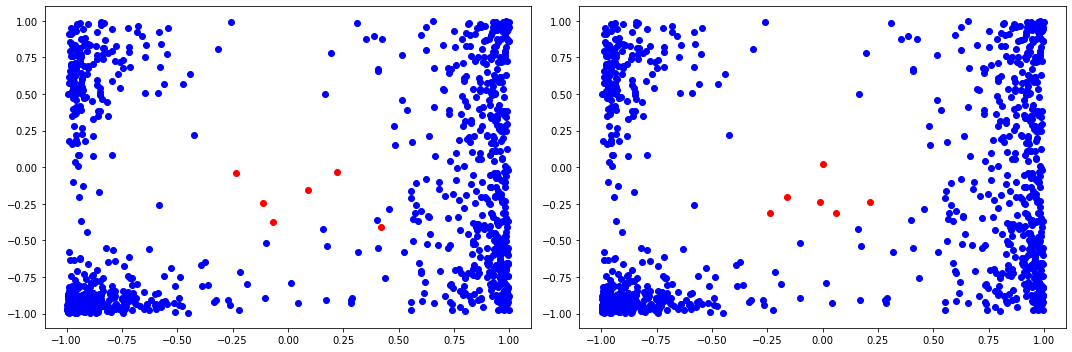

In [41]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1], color="red")

plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_15[:, 0], Bayes_Centers_15[:, 1], color="red")
plt.tight_layout()
plt.show()